<a href="https://colab.research.google.com/github/SarahMcEliece/DTSA-5511-Deep-Learning/blob/main/Week5_Monet/Week_5_Monet_GAN_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DTSA 5511 Week 5 GAN project: I’m Something of a Painter Myself
## Use GANs to create art - will you be the next Monet?
Sarah McEliece 04/28/23

# About and Citations
The project and dataset are taken from the kaggle competetion:

Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

They describe the project as:


> 
>We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!
>
>Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

As suggested in the kaggle project notes, I also relied heavily on and took code snippets from Amy Jang's notebook that goes over the basics of loading data from TFRecords, using TPUs, and building a CycleGAN specifically for loading and outputting data. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook



# Download neccesary packages and get data

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2.12.0


In [2]:
! pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 21.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
! pip install kaggle
! mkdir /content/.kaggle
! cp /kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download gan-getting-started
! unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e71a4094.jpg  
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391

In [5]:
#code to import data slightly adjusted from notebook cited above
GCS_PATH = '/content'


MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Monet TFRecord Files: 5
Photo TFRecord Files: 20


# EDA

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(30)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(30)

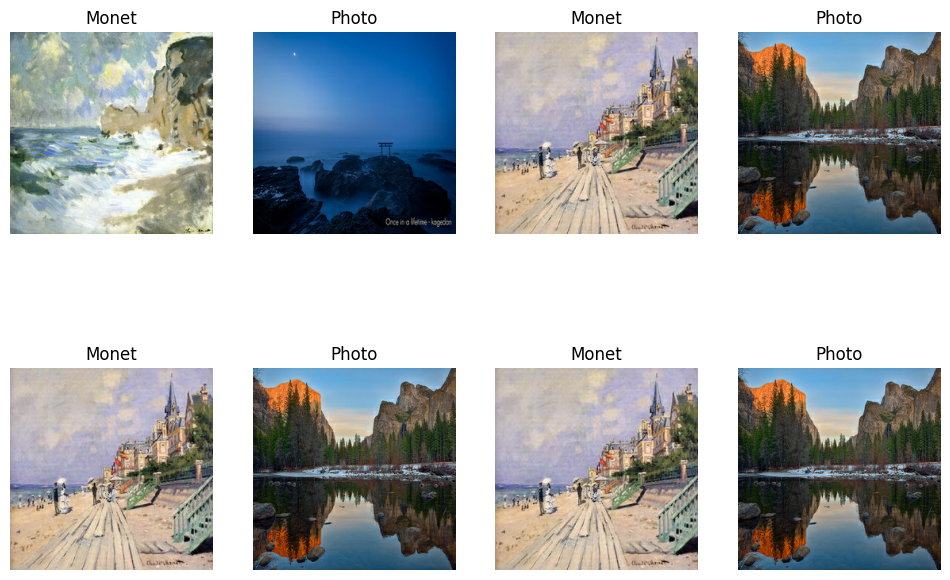

In [7]:
#show a few examples of each image
num_rows = 2 
num_cols = 4

batch_size = num_rows * num_cols // 2

monet_batch = next(iter(monet_ds))
photo_batch = next(iter(photo_ds))

# Create a figure with a grid plot of the images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(num_rows):
    for j in range(num_cols // 2):
        index = np.random.randint(batch_size)
        axes[i][j*2].imshow(monet_batch[index] * 0.5 + 0.5)
        axes[i][j*2].set_title('Monet')
        axes[i][j*2].axis('off')

        axes[i][j*2 + 1].imshow(photo_batch[index] * 0.5 + 0.5)
        axes[i][j*2 + 1].set_title('Photo')
        axes[i][j*2 + 1].axis('off')

plt.show()

# Now I'll just peak at what a raw data file looks like

In [8]:
print(next(iter(monet_ds))[0])

tf.Tensor(
[[[ 0.43529415  0.02745104 -0.05882353]
  [ 0.52156866  0.11372554  0.01176476]
  [ 0.60784316  0.22352946  0.11372554]
  ...
  [ 0.39607847  0.30980396  0.2941177 ]
  [ 0.37254906  0.28627455  0.27058828]
  [ 0.34901965  0.26274514  0.24705887]]

 [[ 0.37254906 -0.01960784 -0.10588235]
  [ 0.48235297  0.09803927 -0.01176471]
  [ 0.6         0.22352946  0.11372554]
  ...
  [ 0.3411765   0.254902    0.23921573]
  [ 0.30980396  0.22352946  0.20784318]
  [ 0.27843142  0.19215691  0.17647064]]

 [[ 0.3176471  -0.05882353 -0.16862744]
  [ 0.45882356  0.082353   -0.02745098]
  [ 0.5921569   0.2313726   0.11372554]
  ...
  [ 0.28627455  0.19215691  0.19215691]
  [ 0.26274514  0.1686275   0.1686275 ]
  [ 0.23921573  0.14509809  0.14509809]]

 ...

 [[-0.12156862 -0.54509807 -0.90588236]
  [-0.06666666 -0.4823529  -0.827451  ]
  [-0.1607843  -0.56078434 -0.9137255 ]
  ...
  [ 0.17647064 -0.02745098  0.04313731]
  [ 0.15294123 -0.02745098  0.05098045]
  [ 0.1686275  -0.01176471  0.066

As expected from the data description we have images of shape 256 X 256 with 3-dimensions, since these are RBG type images.

# Creating Discriminator and Generator
As a starting point I'm going to use the DCGAN disciminator and generators we covered in lecture from https://keras.io/examples/generative/dcgan_overriding_train_step/


In [35]:
generator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 256)       524544    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 512)       20

In [10]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)          

In [68]:
#Create training compiling functions for all 4 models 
#function from tutorial notebook cited earlier
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn 
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [66]:
def discriminator_loss(real, generated):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                 reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                      reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  return (real_loss + generated_loss)/2

def generator_loss(generated):
  return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, LAMBDA):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
  loss2 = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss2

In [42]:
monet_gen = generator
photo_gen = generator
monet_dis = discriminator
photo_dis = discriminator 

monet_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
monet_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [37]:
cycle_gan_model = CycleGan(monet_gen, photo_gen, monet_dis, photo_dis)
cycle_gan_model.compile(monet_g_optimizer,photo_g_optimizer,monet_d_optimizer,photo_d_optimizer, generator_loss, discriminator_loss, cycle_loss, identity_loss)

In [38]:
cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 31s 3s/step - monet_gen_loss: 25.7752 - photo_gen_loss: 25.4879 - monet_disc_loss: 0.0262 - photo_disc_loss: 0.0127
Epoch 2/5
10/10 [==============================] - 24s 2s/step - monet_gen_loss: 19.2678 - photo_gen_loss: 18.9554 - monet_disc_loss: 0.0019 - photo_disc_loss: 0.0150
Epoch 3/5
10/10 [==============================] - 25s 3s/step - monet_gen_loss: 18.9641 - photo_gen_loss: 18.5890 - monet_disc_loss: 0.0030 - photo_disc_loss: 0.0067
Epoch 4/5
10/10 [==============================] - 25s 2s/step - monet_gen_loss: 18.3307 - photo_gen_loss: 17.9157 - monet_disc_loss: 0.0084 - photo_disc_loss: 0.0108
Epoch 5/5
10/10 [==============================] - 25s 2s/step - monet_gen_loss: 35.8152 - photo_gen_loss: 35.3742 - monet_disc_loss: 0.3014 - photo_disc_loss: 0.6322


# First model output

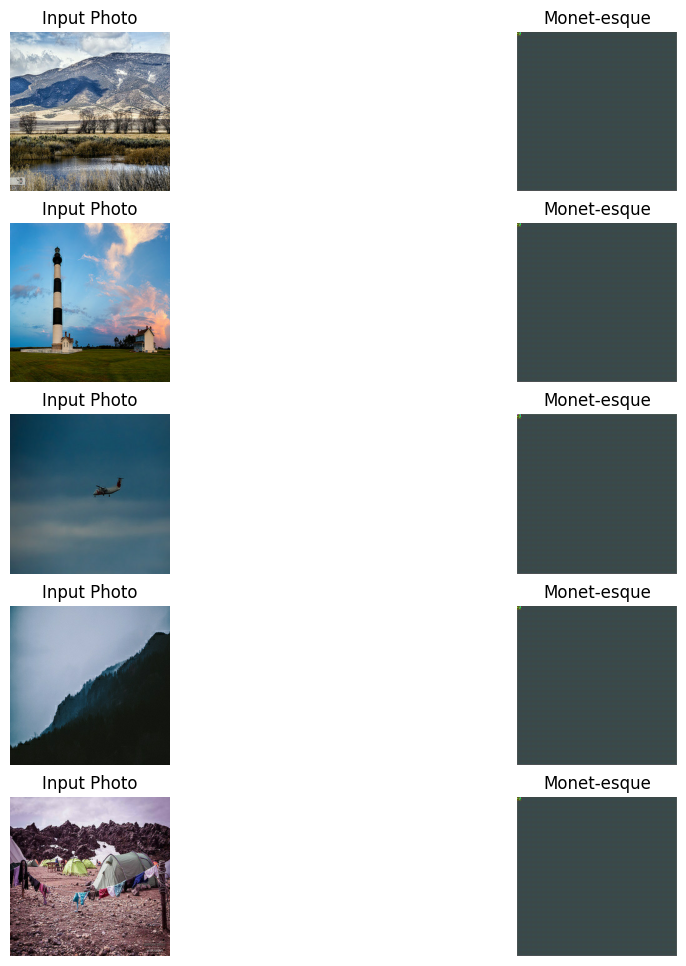

In [39]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Well I think it's obvious something went wrong here. Googling around, I think the issue is I have no normalization built in. Let's try that.

In [64]:
generator = keras.Sequential(
     
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)


generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 128, 128, 64)      3136      
                                                                 
 batch_normalization_133 (Ba  (None, 128, 128, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_169 (LeakyReLU)  (None, 128, 128, 64)     0         
                                                                 
 conv2d_102 (Conv2D)         (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_134 (Ba  (None, 64, 64, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_170 (LeakyReLU)  (None, 64, 64, 128)      0 

Epoch 1/15
10/10 [==============================] - 48s 3s/step - monet_gen_loss: 11.6814 - photo_gen_loss: 11.9745 - monet_disc_loss: 295.9650 - photo_disc_loss: 303.2851
Epoch 2/15
10/10 [==============================] - 25s 3s/step - monet_gen_loss: 14.7848 - photo_gen_loss: 15.6504 - monet_disc_loss: 120.2359 - photo_disc_loss: 115.9875
Epoch 3/15
10/10 [==============================] - 26s 3s/step - monet_gen_loss: 13.7924 - photo_gen_loss: 15.4227 - monet_disc_loss: 104.3571 - photo_disc_loss: 74.8476
Epoch 4/15
10/10 [==============================] - 26s 3s/step - monet_gen_loss: 14.2293 - photo_gen_loss: 16.4497 - monet_disc_loss: 67.2152 - photo_disc_loss: 47.5348
Epoch 5/15
10/10 [==============================] - 26s 3s/step - monet_gen_loss: 24.4852 - photo_gen_loss: 26.4050 - monet_disc_loss: 67.2672 - photo_disc_loss: 35.9143
Epoch 6/15
10/10 [==============================] - 27s 3s/step - monet_gen_loss: 24.3152 - photo_gen_loss: 26.6922 - monet_disc_loss: 48.3804 - 

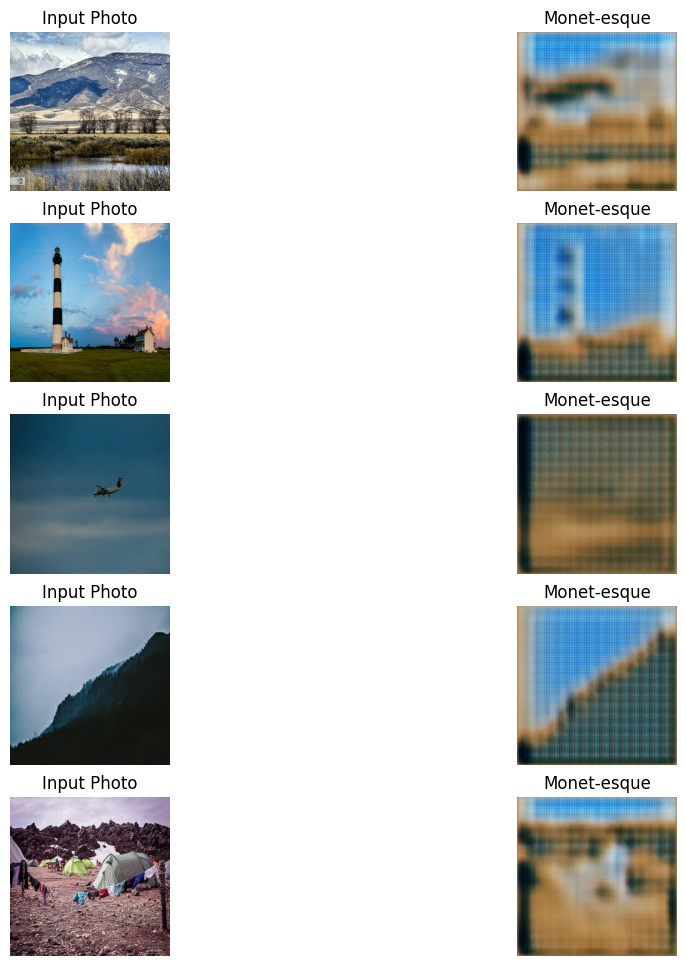

In [67]:
monet_gen = generator
photo_gen = generator
monet_dis = discriminator
photo_dis = discriminator 

monet_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
monet_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_d_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)


cycle_gan_model = CycleGan(monet_gen, photo_gen, monet_dis, photo_dis)
cycle_gan_model.compile(monet_g_optimizer,photo_g_optimizer,monet_d_optimizer,
                        photo_d_optimizer, generator_loss, discriminator_loss, cycle_loss, identity_loss)

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=15)

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

Epoch 1/50
10/10 [==============================] - 30s 3s/step - monet_gen_loss: 26.9974 - photo_gen_loss: 24.5437 - monet_disc_loss: 20.9487 - photo_disc_loss: 16.5307
Epoch 2/50
10/10 [==============================] - 27s 3s/step - monet_gen_loss: 19.2833 - photo_gen_loss: 20.2269 - monet_disc_loss: 24.4390 - photo_disc_loss: 15.9344
Epoch 3/50
10/10 [==============================] - 27s 3s/step - monet_gen_loss: 15.3094 - photo_gen_loss: 15.4922 - monet_disc_loss: 19.2740 - photo_disc_loss: 13.1270
Epoch 4/50
10/10 [==============================] - 26s 3s/step - monet_gen_loss: 13.8652 - photo_gen_loss: 13.5833 - monet_disc_loss: 17.1901 - photo_disc_loss: 14.1849
Epoch 5/50
10/10 [==============================] - 27s 3s/step - monet_gen_loss: 14.4598 - photo_gen_loss: 13.2062 - monet_disc_loss: 15.6634 - photo_disc_loss: 12.5478
Epoch 6/50
10/10 [==============================] - 27s 3s/step - monet_gen_loss: 14.4492 - photo_gen_loss: 14.8062 - monet_disc_loss: 13.7855 - photo

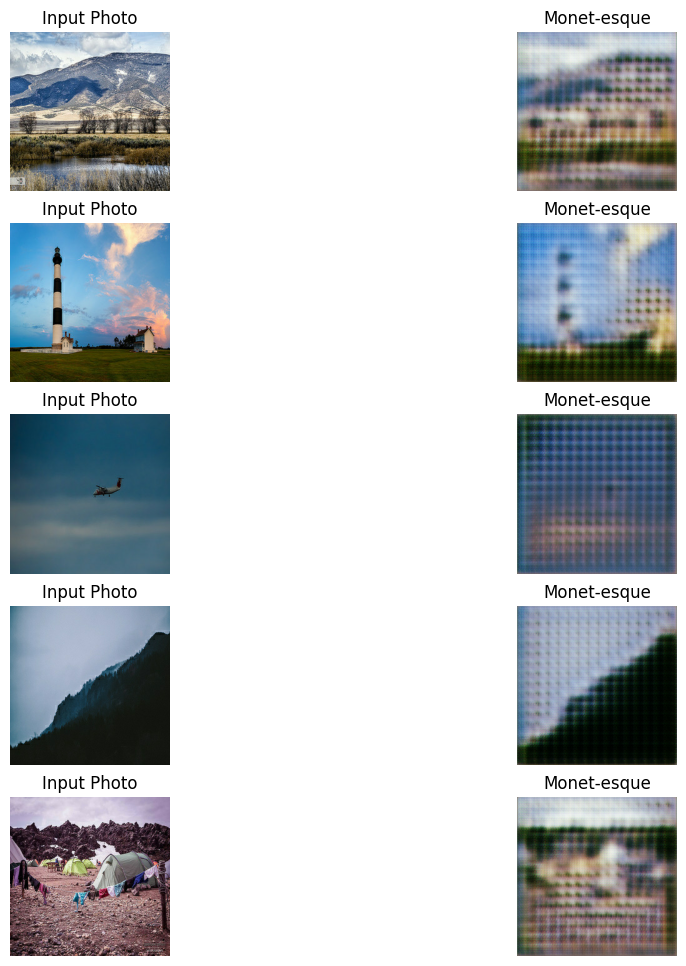

In [69]:
cycle_gan_model = CycleGan(monet_gen, photo_gen, monet_dis, photo_dis)
cycle_gan_model.compile(monet_g_optimizer,photo_g_optimizer,monet_d_optimizer,
                        photo_d_optimizer, generator_loss, discriminator_loss, cycle_loss, identity_loss)

cycle_gan_model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)),epochs=50)

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

After this model I ran a few more in Kaggle, changing the kernel size from 4 to 3 in my generator models, that resulted in images that looked like this:

then adding dropout layers to my discriminator.when I went to run my model in a Kaggle notebook, I realized I needed to make my discriminator model less specific. It was quickly overtrainning, limiting how much my generators could improve. My Final model looks like: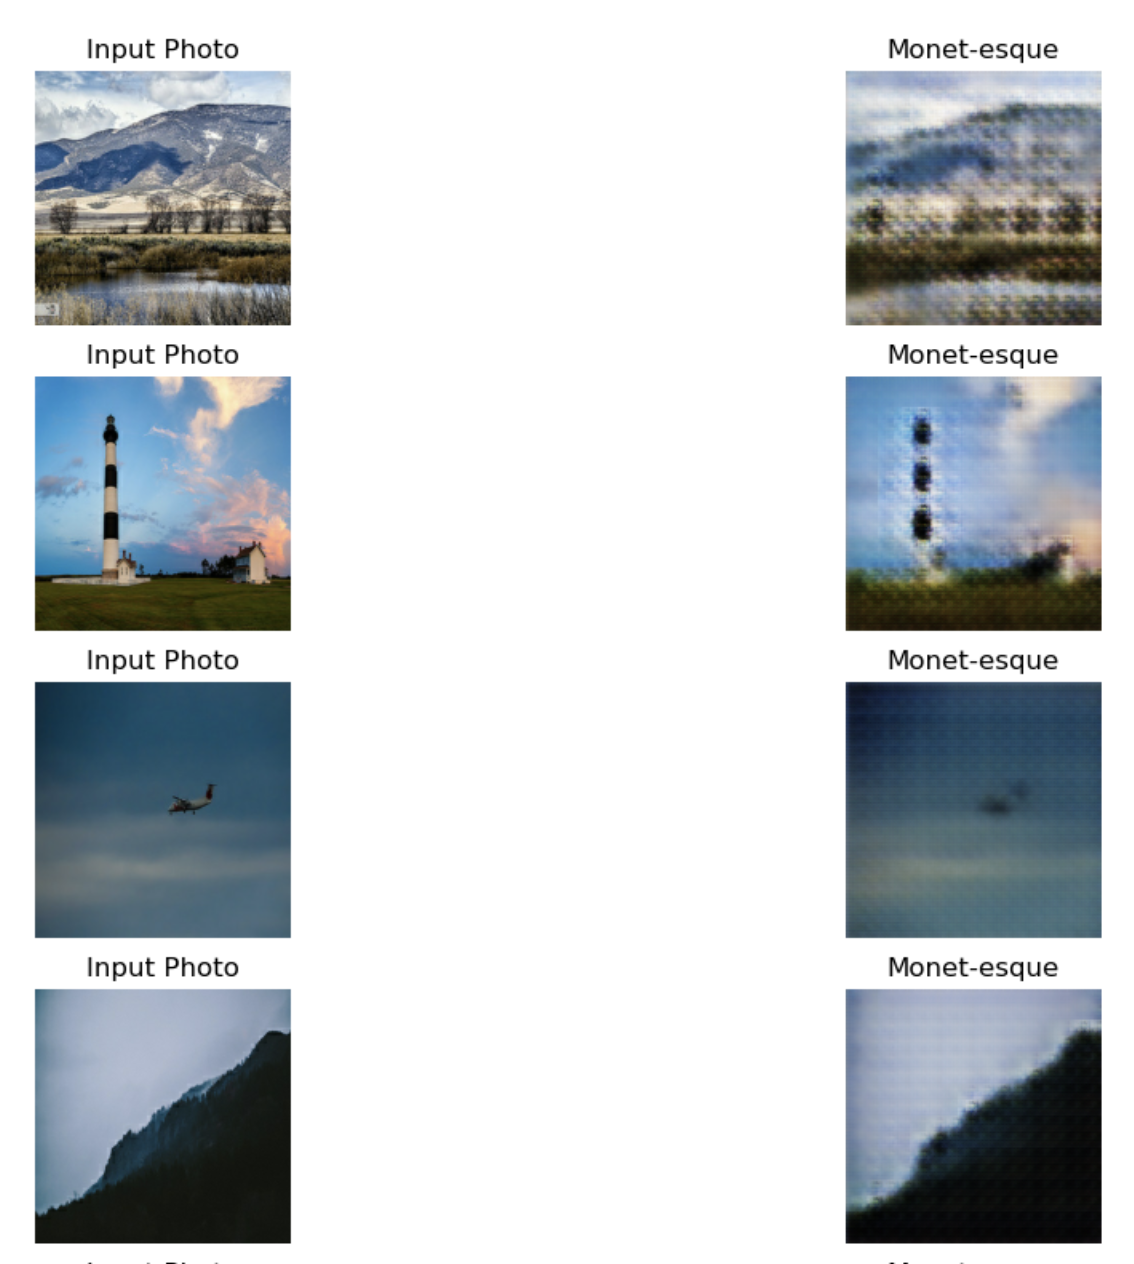

Then I realized my discriminator was overfitting, because the loss got very very small while the generator remained pretty much unchanged/increaced. The final models:



```
   generator = keras.Sequential(
     
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2D(256, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2D(512, kernel_size=3, strides=2, padding="same", kernel_initializer=tf.random_normal_initializer(0., 0.02)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.6),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="tanh"),
    ],
    name="generator",
)
```


```
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()
```
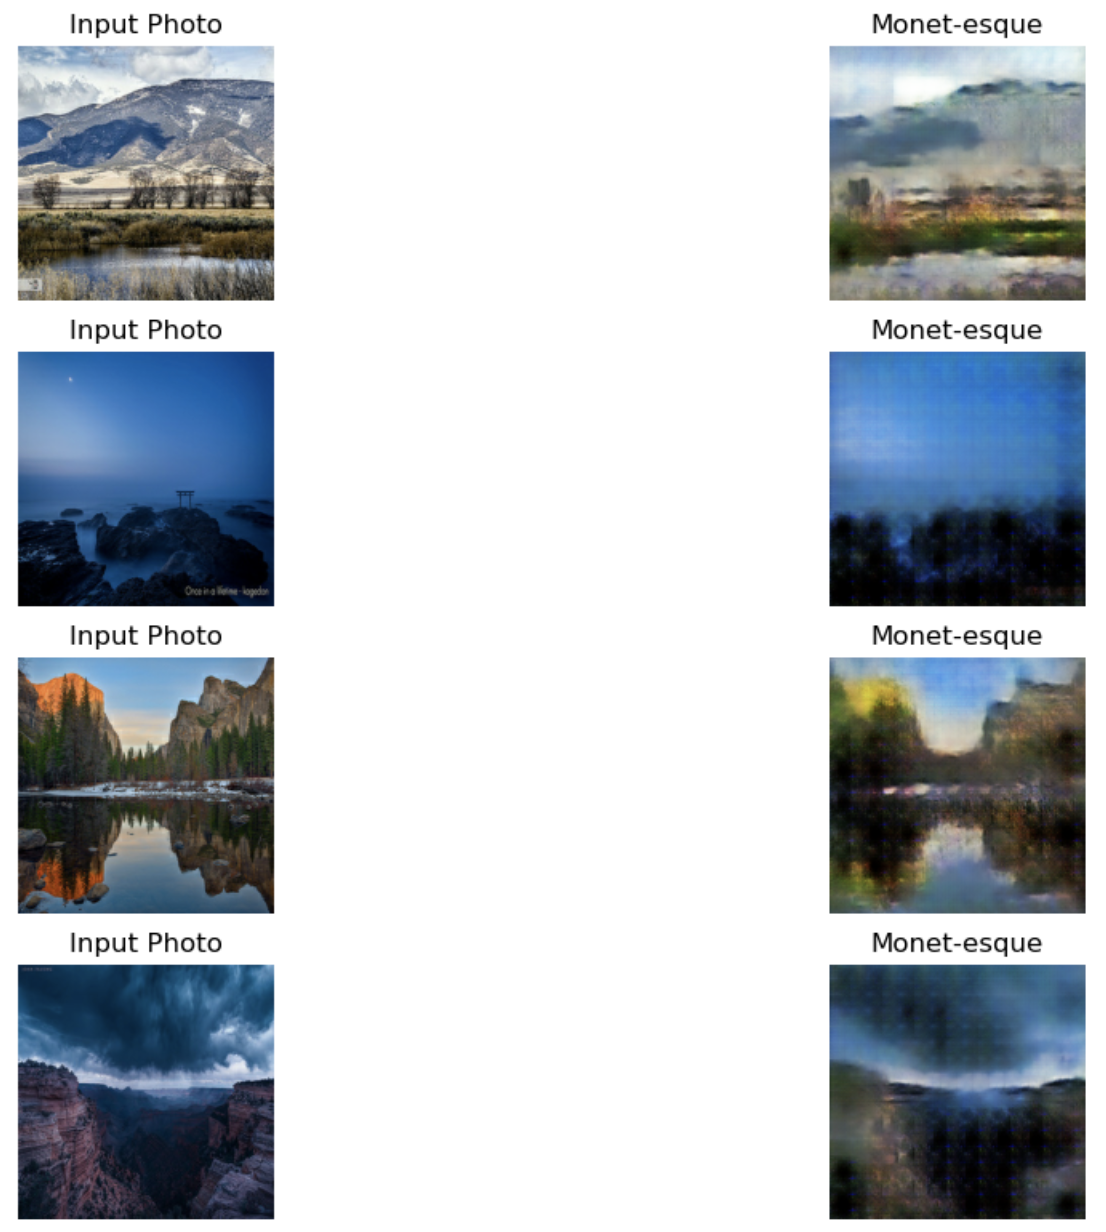


# Summarary and next steps
I struggled with this project quite a bit. I had to rely very heavily on the provided template code after trying time and time again to modify the GAN code to take in an image as a starting point. At the end of the day, once I actually got my model to work there were a few key steps to my model's moderate success:


*   Dropout layers! If i've learned anything from these Kaggle projects, is you need to be aggressive with dropout layers or the model WILL over train and quickly
*   Normalization is also critical, this took me from essentially a solid picture to a model that actually resembled the previous photo
*   Your generator is only as good as your discriminator. My discriminator was very simple (and generally still is), and overfit my model very quickly. No matter how i changed the layers in my generator, I couldn't get any imporvement. Adding dropout layers to my discriminator was a huge leap forward.
*  Small kernels, this helped my final image look like something that was not neccesarily generated (to the human eye) because it was less blocky

Next, I would continue trying to improve my discrimnator models by adding more layers and/or increacing dropout normalization.








# Generate new images

In [70]:
import PIL
! mkdir ../images

In [72]:
i = 1
for img in photo_ds:
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [73]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Kaggle score